## Investigate effect of object detections on ADL detection

Check if detections have an impact on the performance of ADL detection by comparing the performance of models trained on detected active objects versus labelled active objects.

In [1]:
import os
import pandas as pd
import egoviz.models.processing as pr
import egoviz.models.evaluation as ev

from collections import Counter

SEED = 42

In [2]:
cwd = os.getcwd()
file_path = os.path.join(cwd, '../data/home_data_eval_all_preds.pkl')
data = pr.load_pickle(file_path)

In [3]:
df_dets = pd.DataFrame(columns=['video', 'frame', 'classes', 'active', 'adl'])

for id, dets in data.items():
    adl = id.split('_', 1)[0]
    video = id.split('_')[1]
    frame = id.split('_')[2]
    classes = dets['detic_data']['labels']
    active = dets['detic_data']['active']

    row = {'video': video, 'frame': frame, 'classes': classes, 'adl': adl, 'active': active}

    df_dets.loc[len(df_dets)] = row

df_dets.head()

,video,frame,classes,active,adl
0,SCI06-7--11,frame49,"[phone_tablet, electronics, furniture, furnitu...","[True, False, False, False, False, False, Fals...",communication-mgmt
1,SCI06-7--11,frame98,"[phone_tablet, furniture, furniture, cabinetry...","[True, False, False, False, False, False, Fals...",communication-mgmt
2,SCI06-7--11,frame196,"[phone_tablet, cabinetry, furniture, furniture...","[True, False, False, False, False, False, Fals...",communication-mgmt
3,SCI06-7--11,frame147,"[phone_tablet, furniture, cabinetry, cabinetry...","[True, False, False, False, False, False, Fals...",communication-mgmt
4,SCI06-7--11,frame294,"[phone_tablet, furniture, kitchen_appliance, f...","[True, False, False, False, False, False, Fals...",communication-mgmt


In [4]:
df_truth = pd.DataFrame(columns=['video', 'frame', 'classes', 'active', 'adl'])

for id, dets in data.items():
    adl = id.split('_', 1)[0]
    video = id.split('_')[1]
    frame = id.split('_')[2]
    classes = dets['ground_truth']['labels']
    active = dets['ground_truth']['active']

    row = {'video': video, 'frame': frame, 'classes': classes, 'adl': adl, 'active': active}

    df_truth.loc[len(df_truth)] = row

df_truth.head()

,video,frame,classes,active,adl
0,SCI06-7--11,frame49,"[phone_tablet, furniture, furniture, electronics]","[True, False, False, False]",communication-mgmt
1,SCI06-7--11,frame98,"[phone_tablet, furniture, furniture, electroni...","[True, False, False, False, False]",communication-mgmt
2,SCI06-7--11,frame196,"[food, phone_tablet, furniture, furniture]","[False, True, False, False]",communication-mgmt
3,SCI06-7--11,frame147,"[phone_tablet, furniture, furniture, food]","[True, False, False, False]",communication-mgmt
4,SCI06-7--11,frame294,"[food, phone_tablet, furniture, furniture]","[False, True, False, False]",communication-mgmt


In [5]:
def count_occurrences(classes, active):
    class_counts = Counter(classes)
    active_counts = Counter({cls: sum([act and (cls == c) for act, c in zip(active, classes)]) for cls in set(classes)})
    return class_counts, active_counts

# Apply the function to create new columns
df_dets['class_counts'], df_dets['active_counts'] = zip(*df_dets.apply(lambda row: count_occurrences(row['classes'], row['active']), axis=1))
df_truth['class_counts'], df_truth['active_counts'] = zip(*df_truth.apply(lambda row: count_occurrences(row['classes'], row['active']), axis=1))

In [6]:
def process_df(df):
    # Create a new DataFrame from class_counts and active_counts
    counts_df = pd.DataFrame(df.apply(lambda row: {'adl': row['adl'], 'video': row['video'], **{f'count_{key}': value for key, value in row['class_counts'].items()}, **{f'active_{key}': value for key, value in row['active_counts'].items()}}, axis=1).tolist())
    # Group by video and sum the values for each video
    grouped_counts_df = counts_df.groupby('video').agg({**{'adl': 'first'}, **{col: 'sum' for col in counts_df.columns if col not in ['adl', 'video']}})

    return grouped_counts_df.reset_index()

In [7]:
df_truth_processed = process_df(df_truth)
df_dets_processed = process_df(df_dets)

In [8]:
df_truth_processed.head()

,video,adl,count_phone_tablet,count_furniture,count_electronics,active_phone_tablet,active_electronics,active_furniture,count_food,active_food,...,count_bathroom_fixture,active_bathroom_fixture,count_cabinetry,active_cabinetry,count_toiletries,active_toiletries,count_home_appliance_tool,active_home_appliance_tool,count_clothing,active_clothing
0,SCI02-1--1,functional-mobility,5.0,2.0,0.0,2.0,0.0,0.0,43.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SCI02-1--2,meal-prep-cleanup,2.0,0.0,0.0,0.0,0.0,0.0,54.0,2.0,...,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0
2,SCI02-2--2,meal-prep-cleanup,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,...,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SCI02-2--9,self-feeding,6.0,2.0,0.0,0.0,0.0,0.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SCI02-4--2,self-feeding,6.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_dets_processed.head()

,video,adl,count_phone_tablet,count_electronics,count_furniture,count_clothing_accessory,count_wheelchair_walker,count_office_stationary,count_footwear,count_bag,...,count_toiletries,active_toiletries,count_plant,active_plant,count_sink,active_sink,count_bathroom_fixture,active_bathroom_fixture,count_hat,active_hat
0,SCI02-1--1,functional-mobility,6.0,3.0,7.0,0.0,0.0,9.0,3.0,4.0,...,1.0,0.0,0.0,0.0,6.0,0.0,4.0,0.0,0.0,0.0
1,SCI02-1--2,meal-prep-cleanup,4.0,3.0,2.0,10.0,0.0,2.0,1.0,1.0,...,3.0,0.0,3.0,0.0,13.0,0.0,11.0,0.0,0.0,0.0
2,SCI02-2--2,meal-prep-cleanup,0.0,0.0,2.0,2.0,0.0,0.0,1.0,3.0,...,2.0,0.0,0.0,0.0,11.0,0.0,4.0,0.0,0.0,0.0
3,SCI02-2--9,self-feeding,10.0,0.0,24.0,4.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SCI02-4--2,self-feeding,12.0,0.0,30.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modeling

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
truth_clf = RandomForestClassifier(n_estimators=100, random_state=SEED)
dets_clf = RandomForestClassifier(n_estimators=100, random_state=SEED)

In [11]:
def train_model(df, clf):
    X = df.drop(['adl', 'video'], axis=1)
    y = df['adl']
    groups = df['video'].str[:5]

    # try all classifiers
    return ev.leave_one_group_out_cv(df, X, y, groups, clf)

2023-11-17 22:05:45,736 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI02


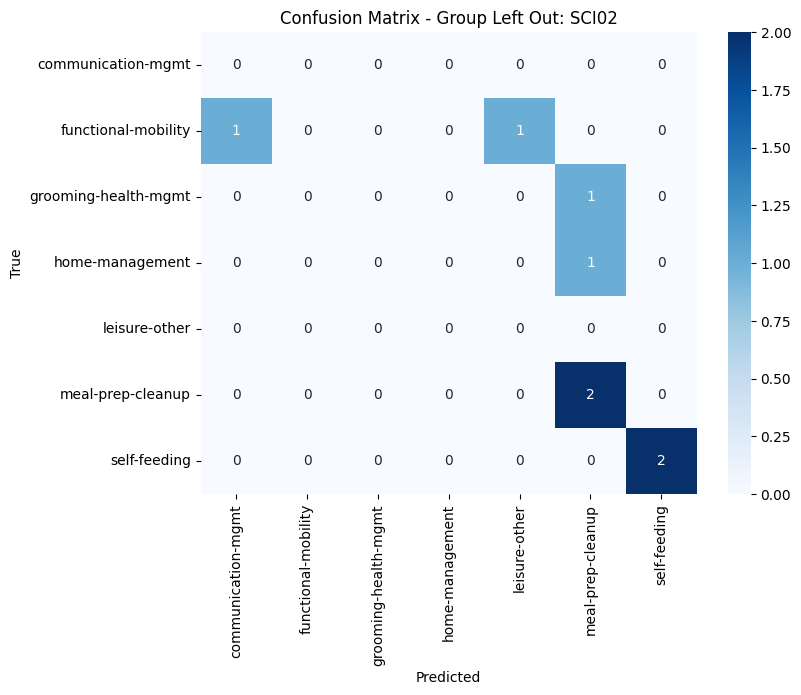

2023-11-17 22:05:45,967 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI03


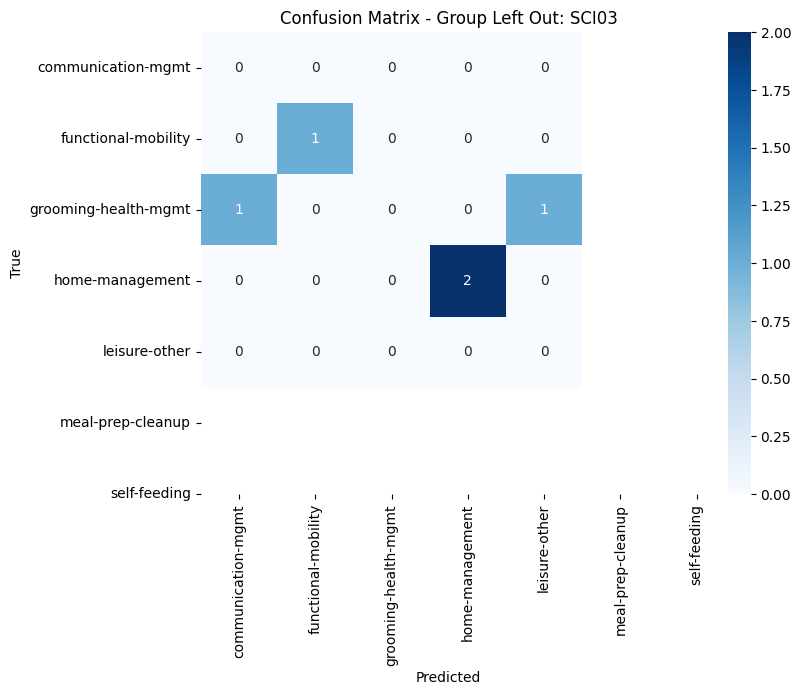

2023-11-17 22:05:46,149 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI06


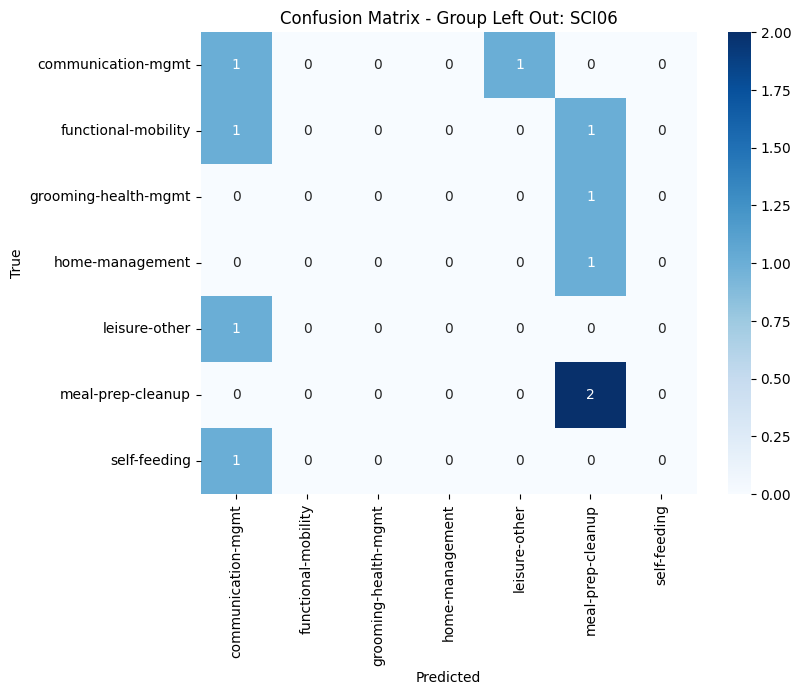

2023-11-17 22:05:46,403 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI08


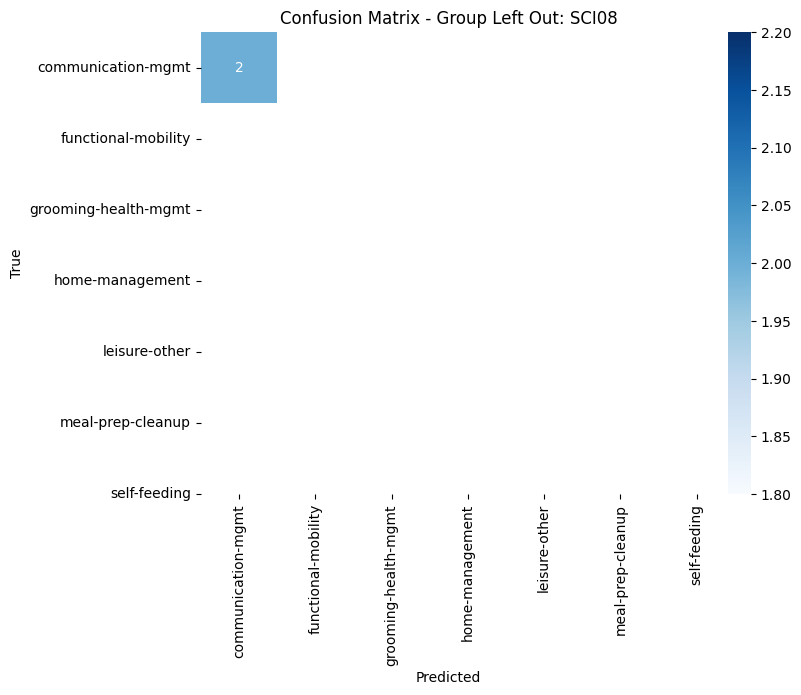

2023-11-17 22:05:46,577 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI10


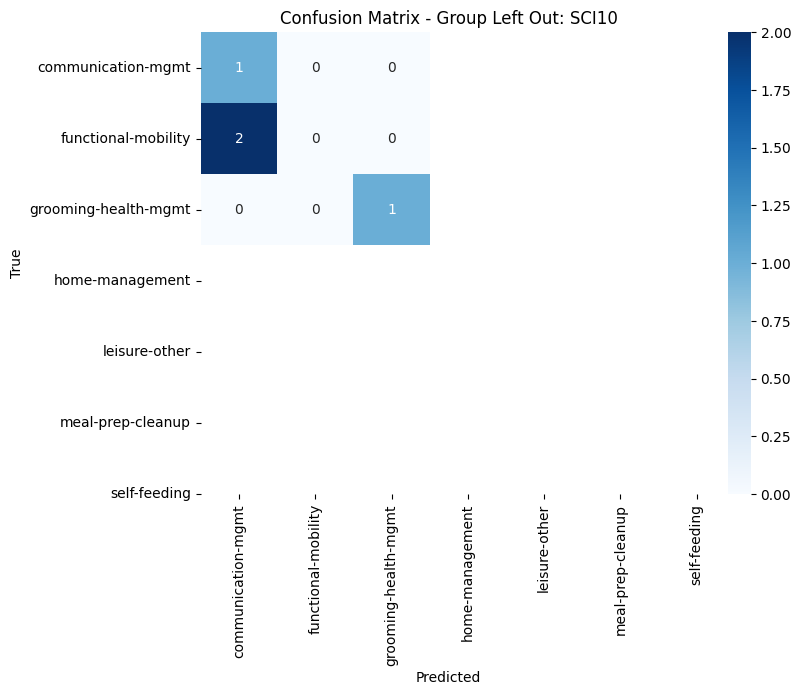

2023-11-17 22:05:46,751 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI11


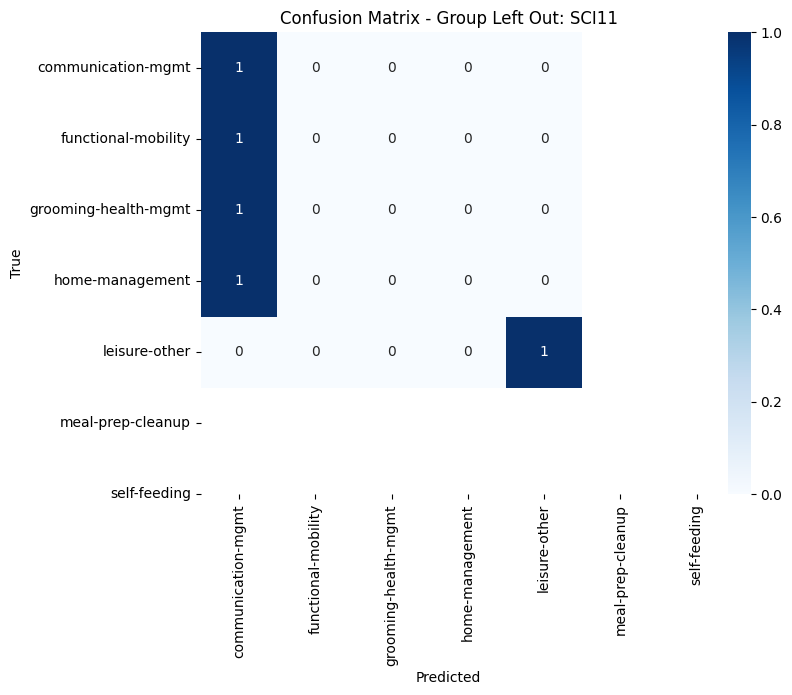

2023-11-17 22:05:46,922 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI12


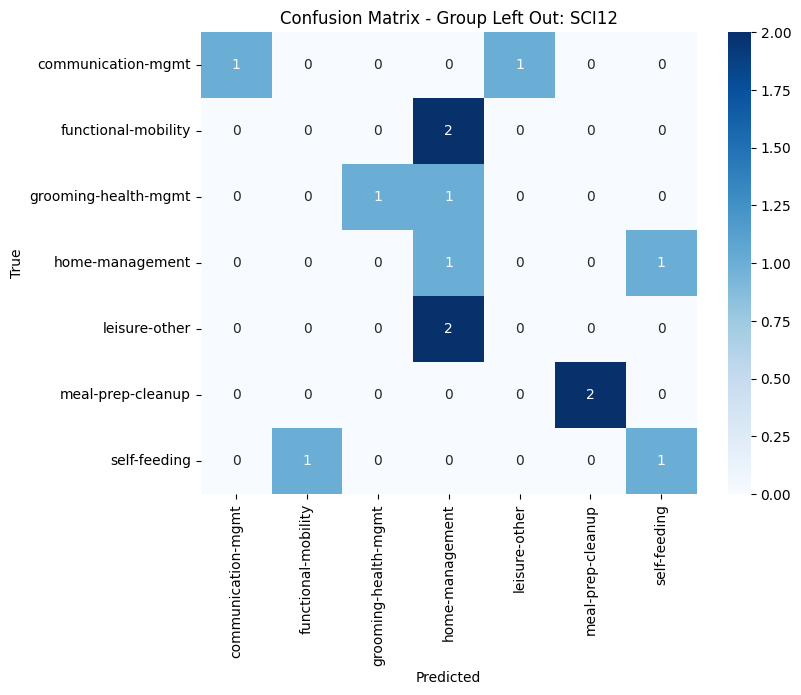

2023-11-17 22:05:47,118 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI13


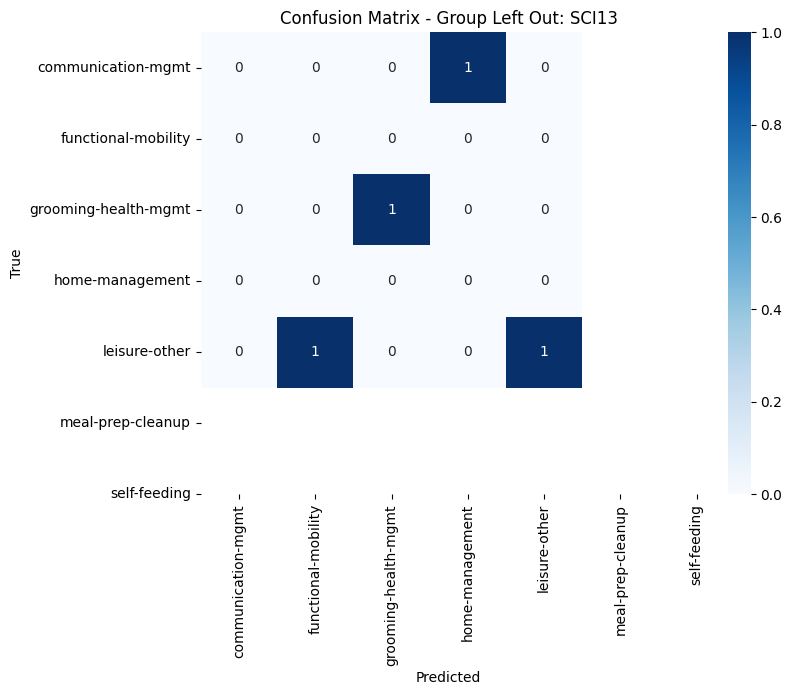

2023-11-17 22:05:47,297 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI14


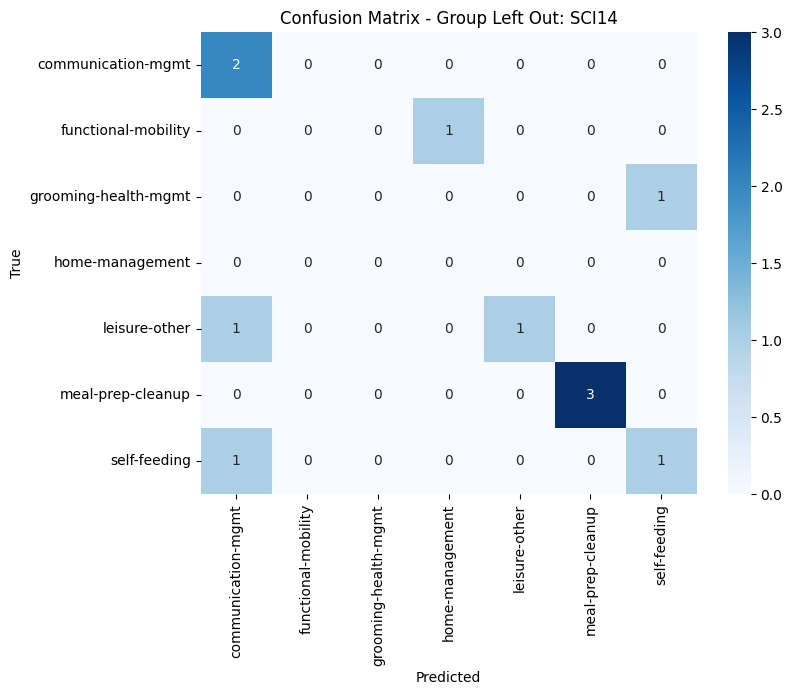

2023-11-17 22:05:47,487 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI15


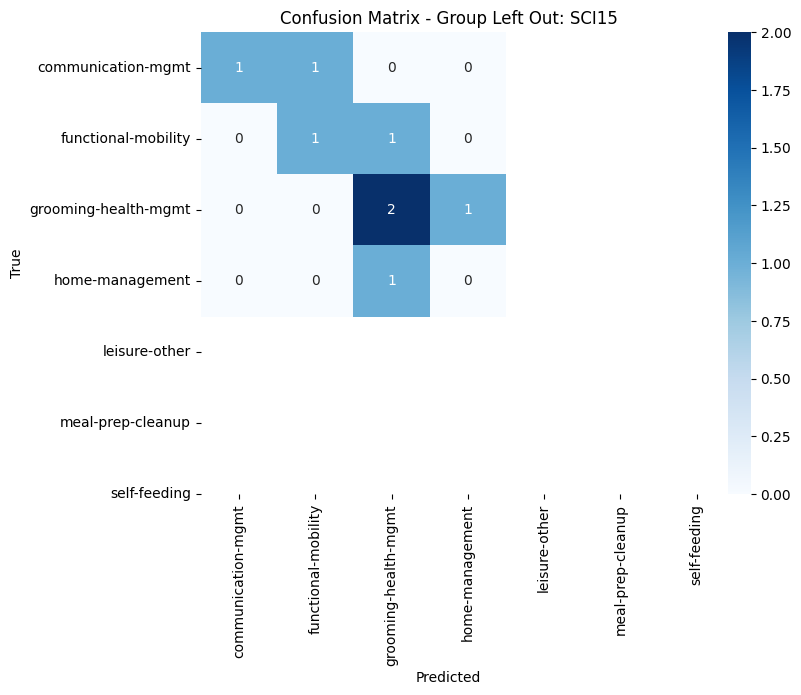

2023-11-17 22:05:47,663 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI16


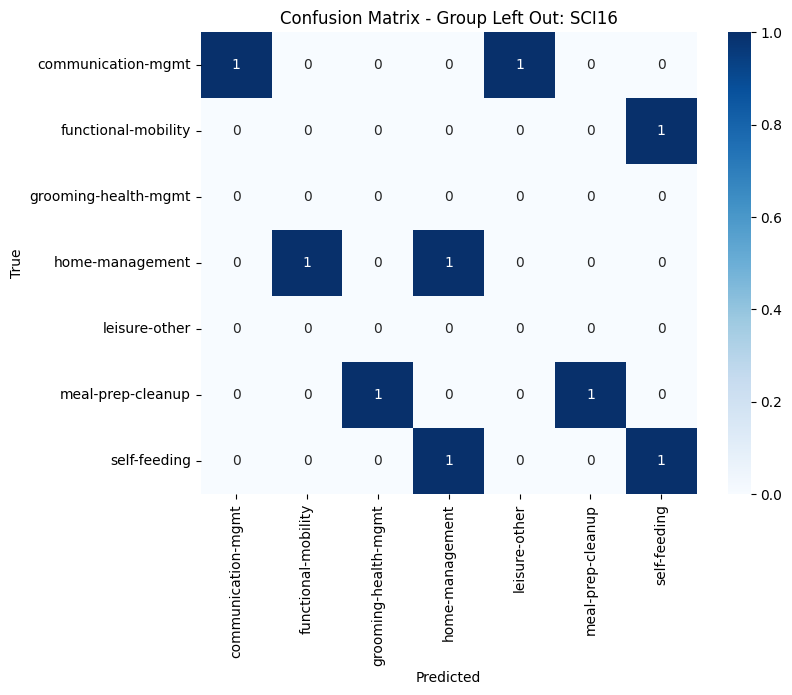

2023-11-17 22:05:47,848 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI17


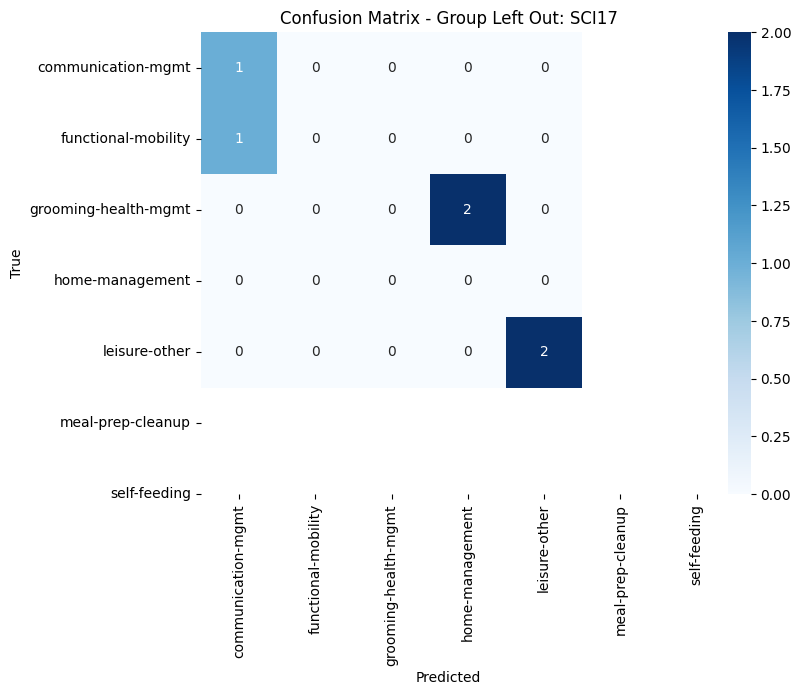

2023-11-17 22:05:48,033 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI18


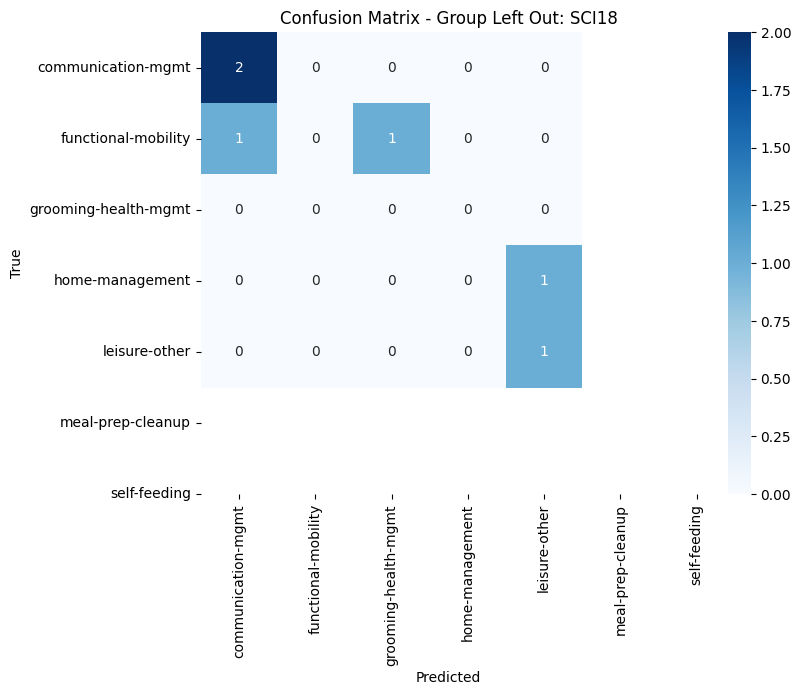

2023-11-17 22:05:48,310 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI19


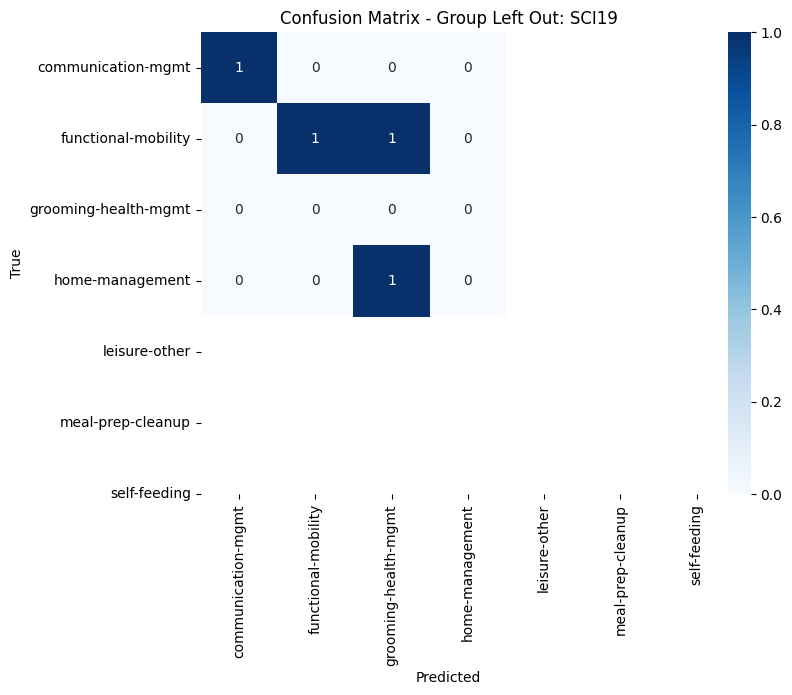

2023-11-17 22:05:48,486 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI20


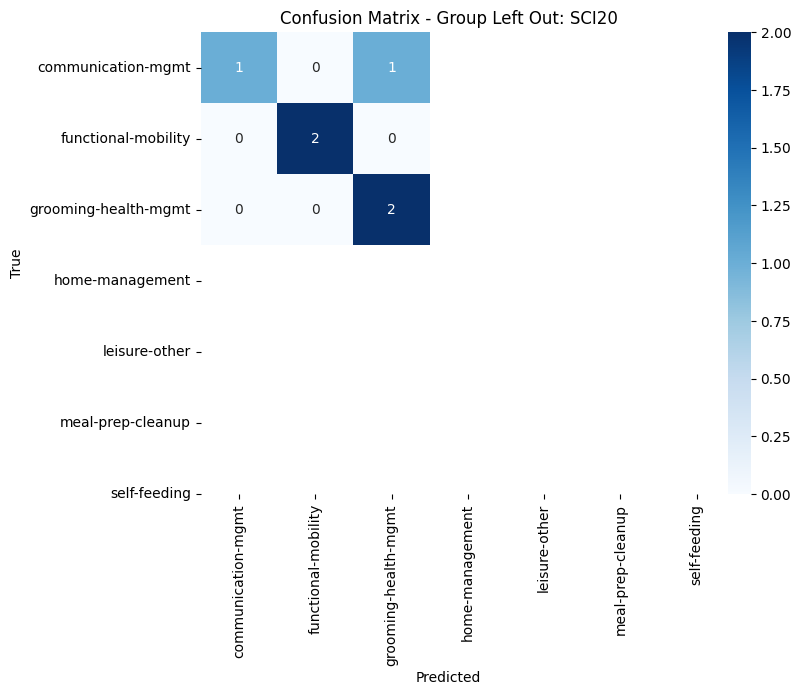

2023-11-17 22:05:48,659 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI21


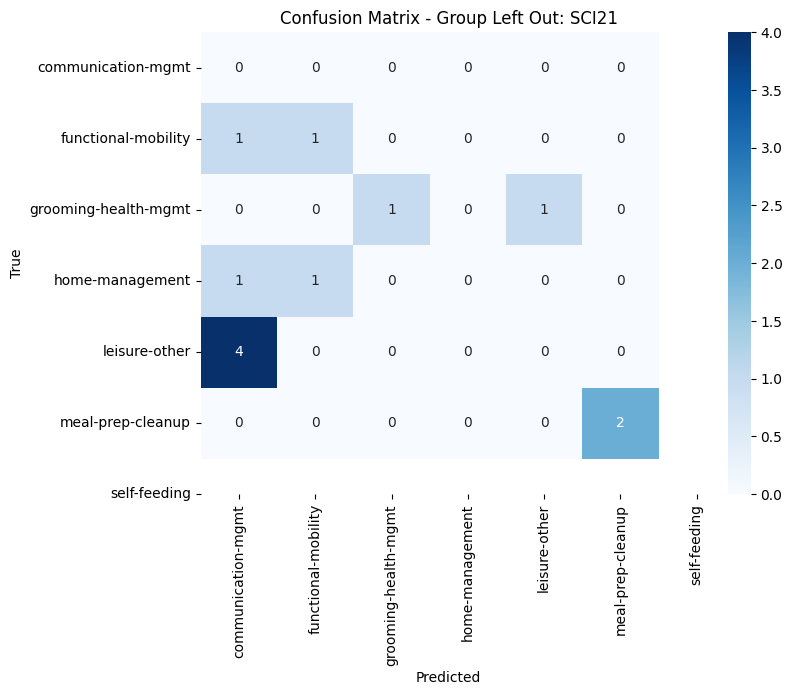

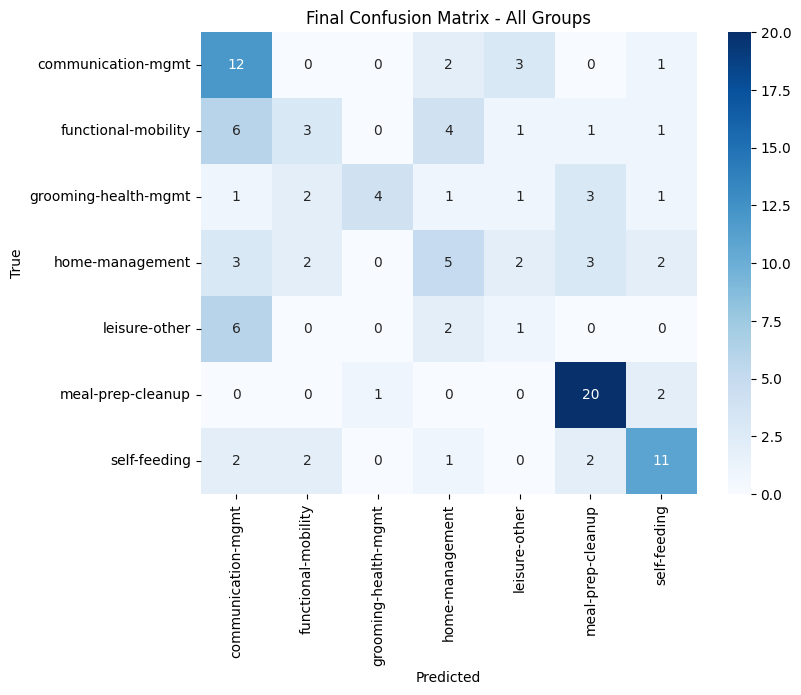

2023-11-17 22:05:48,911 - root - INFO - LOGOCV complete for RandomForestClassifier
2023-11-17 22:05:48,978 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI02


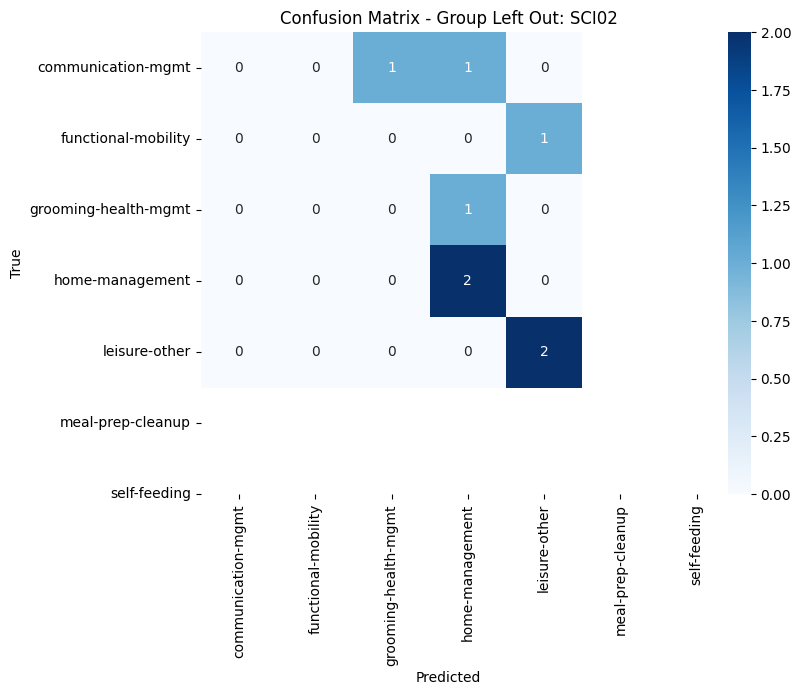

2023-11-17 22:05:49,161 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI03


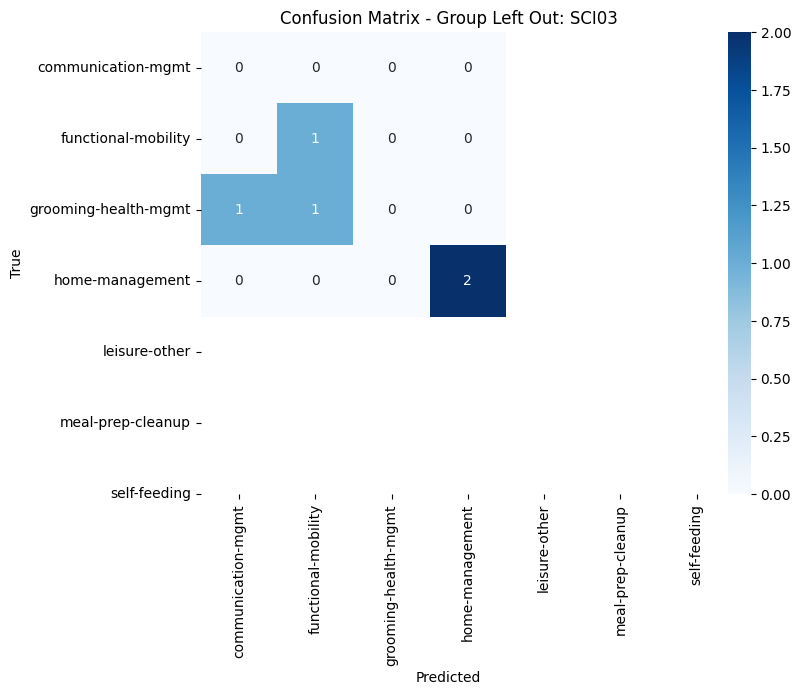

2023-11-17 22:05:49,343 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI06


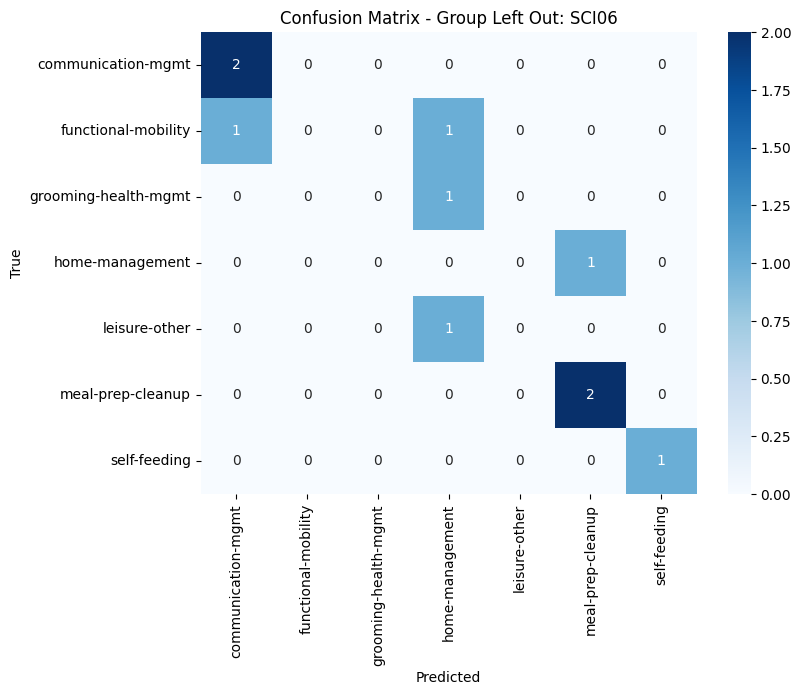

2023-11-17 22:05:49,539 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI08


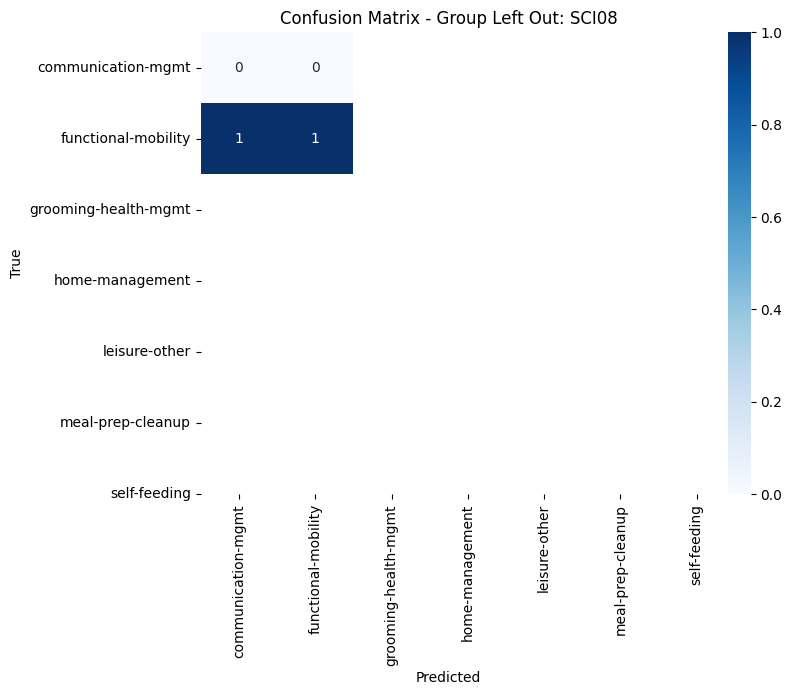

2023-11-17 22:05:49,711 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI10


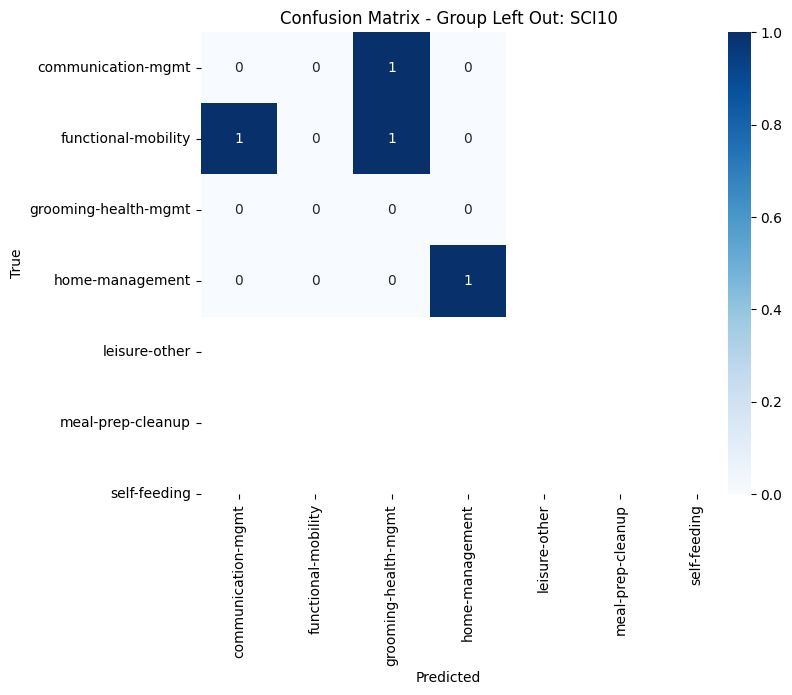

2023-11-17 22:05:49,886 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI11


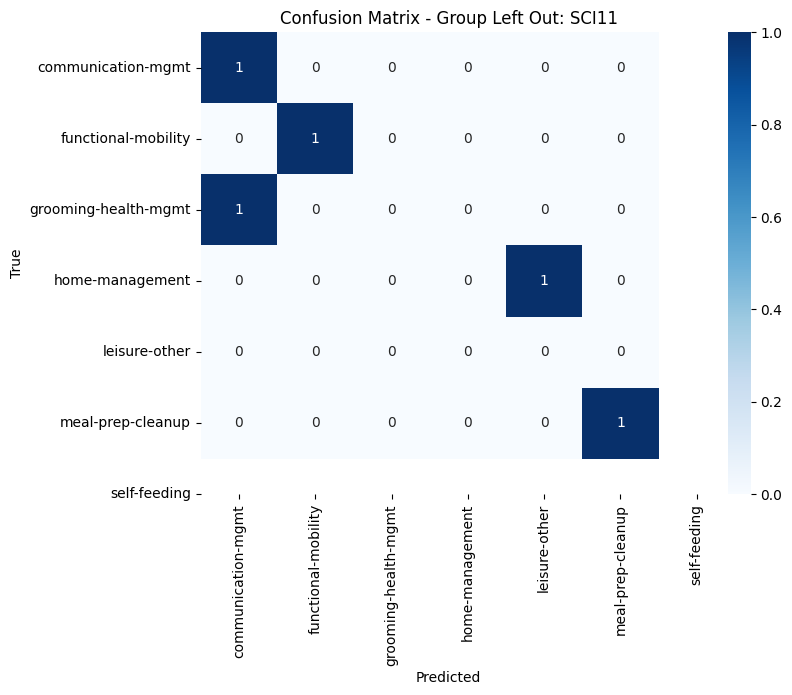

2023-11-17 22:05:50,073 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI12


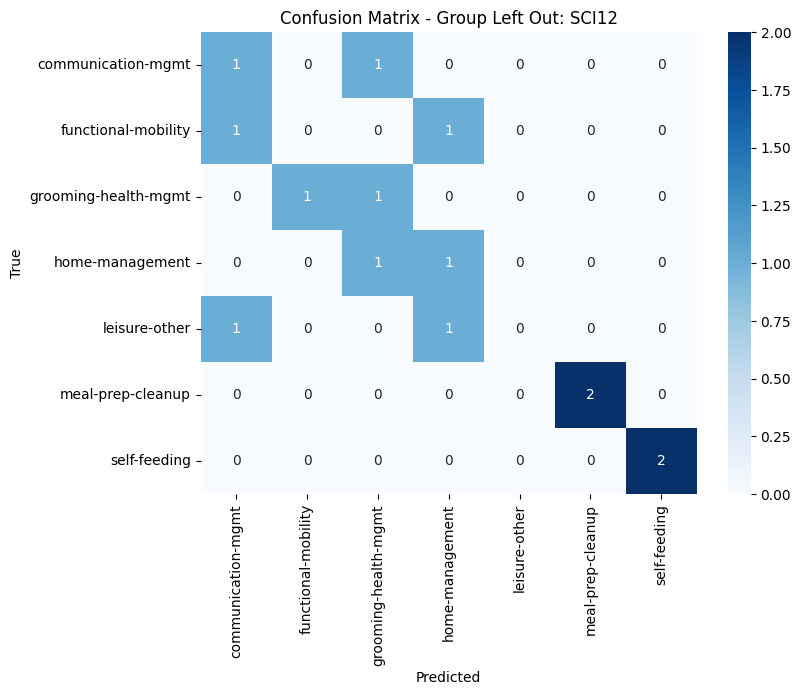

2023-11-17 22:05:50,378 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI13


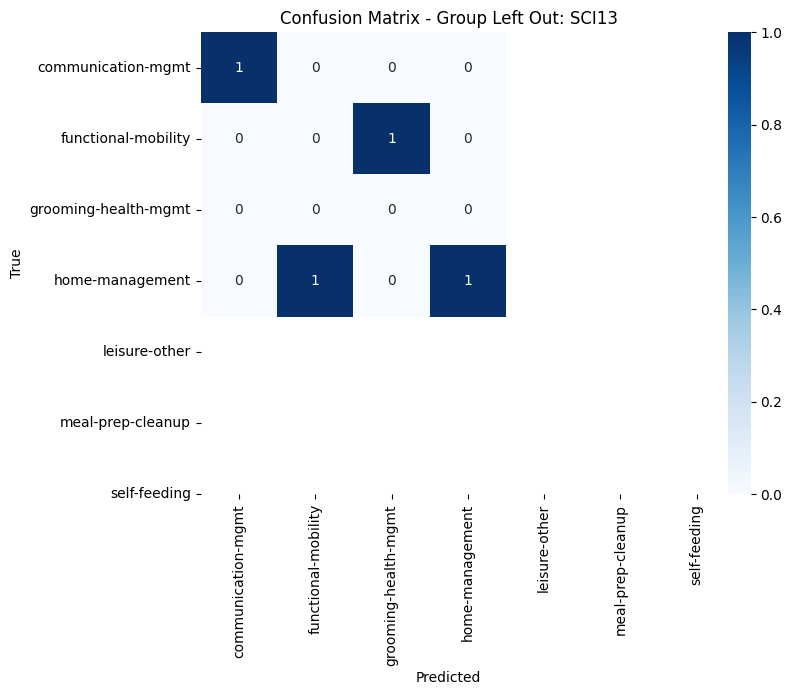

2023-11-17 22:05:50,555 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI14


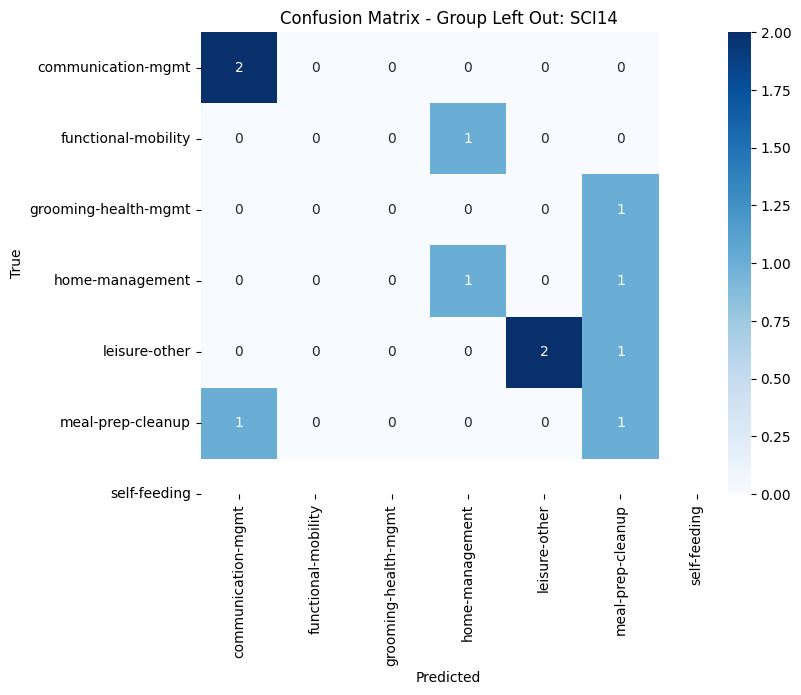

2023-11-17 22:05:50,744 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI15


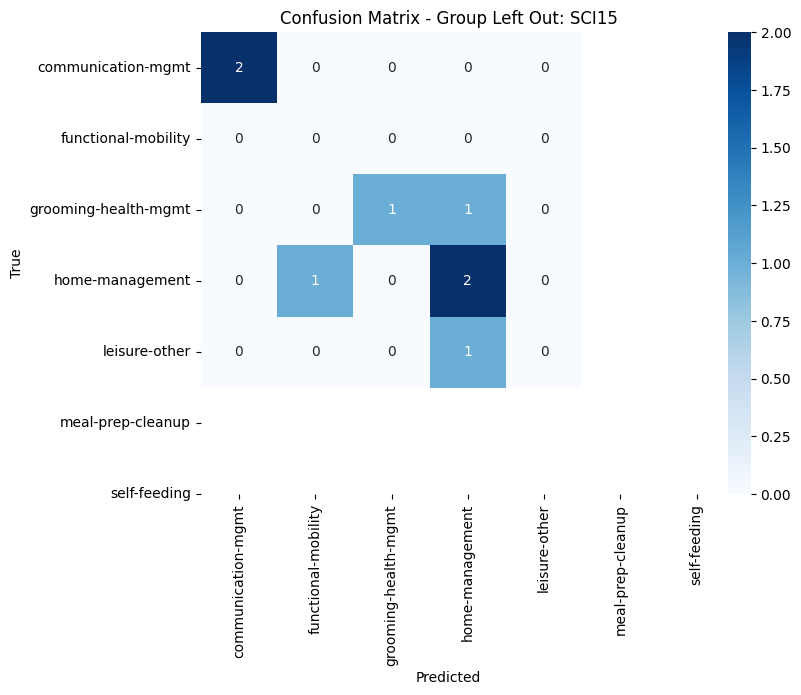

2023-11-17 22:05:50,928 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI16


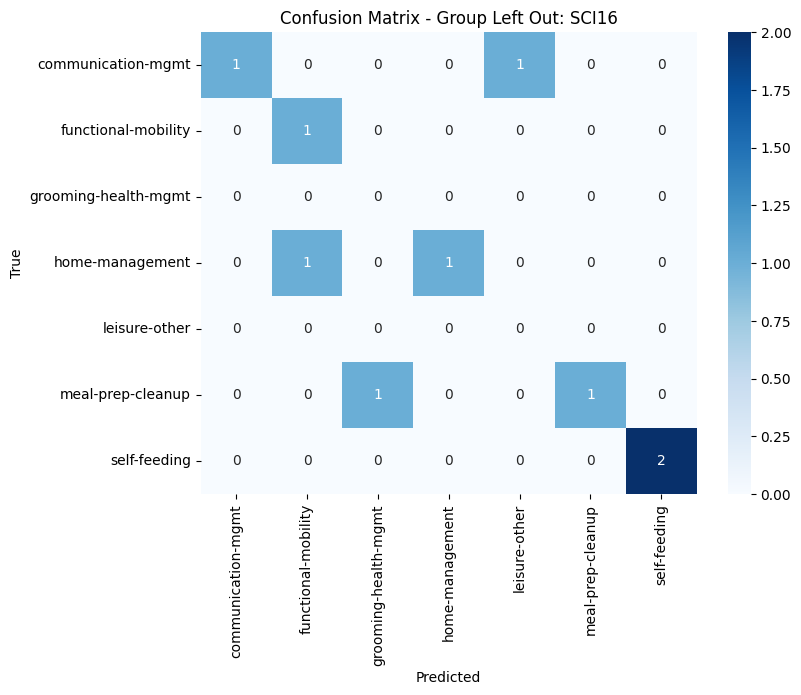

2023-11-17 22:05:51,126 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI17


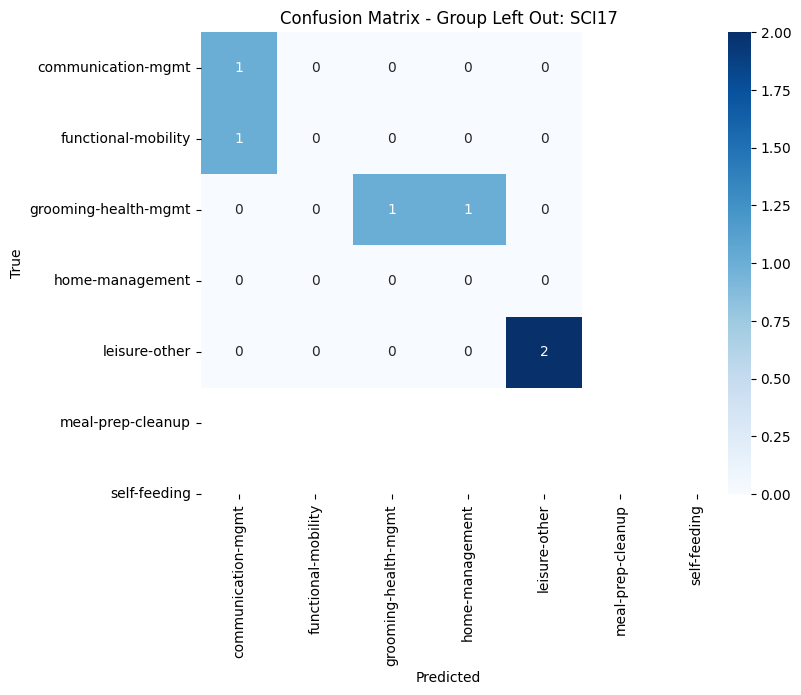

2023-11-17 22:05:51,312 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI18


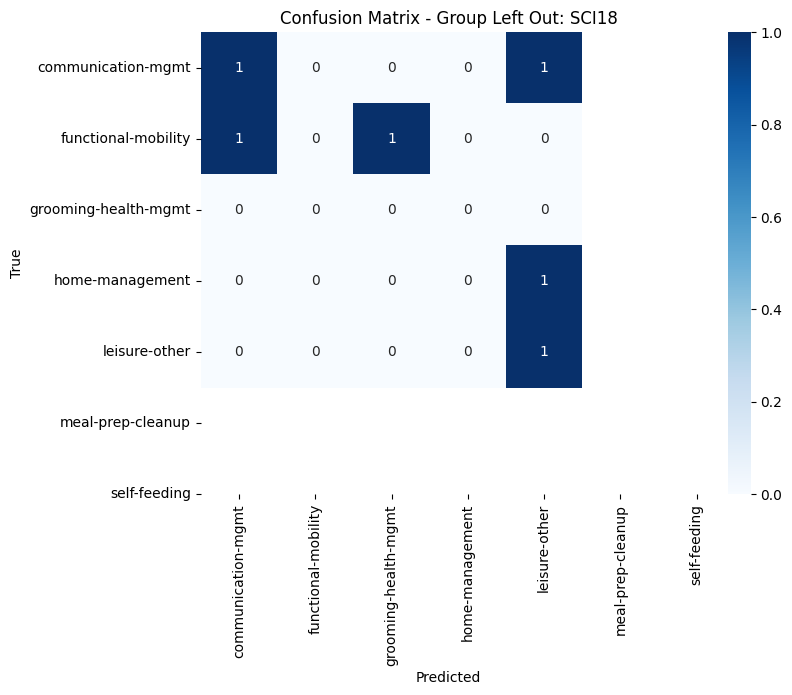

2023-11-17 22:05:51,494 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI19


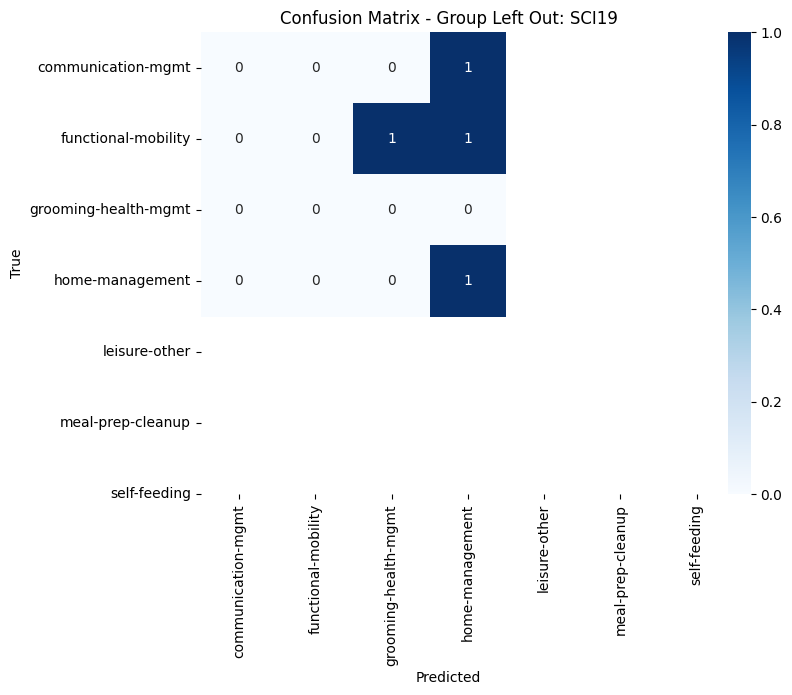

2023-11-17 22:05:51,670 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI20


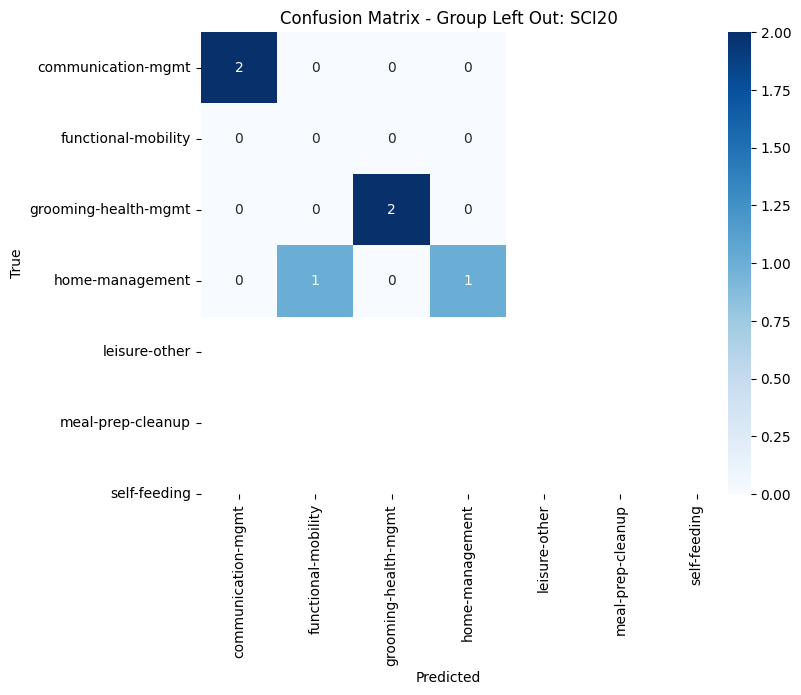

2023-11-17 22:05:51,851 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI21


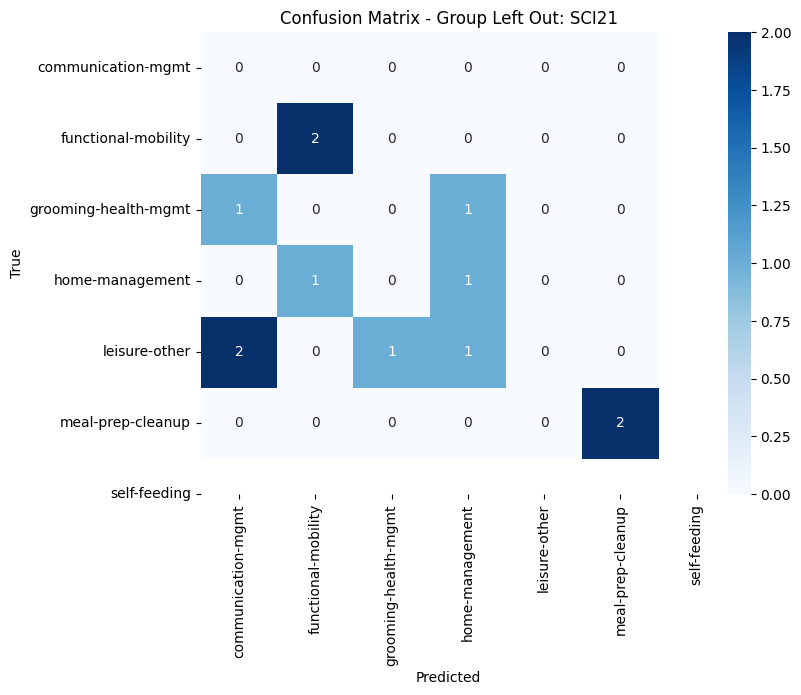

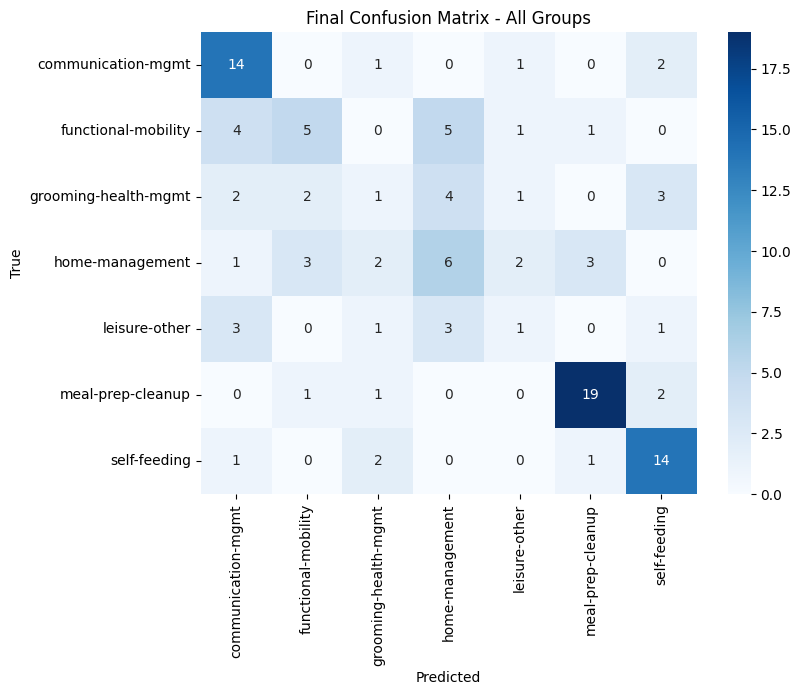

2023-11-17 22:05:52,194 - root - INFO - LOGOCV complete for RandomForestClassifier


In [12]:
rf_truth = train_model(df_truth_processed, truth_clf)
rf_dets = train_model(df_dets_processed, dets_clf)

In [13]:
rf_truth

,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.500000,0.642857,0.571429,0.238095,0.529753,0.678571,0.593676,0.481784
1,SCI03,0.600000,0.600000,0.800000,0.400000,0.529753,0.678571,0.593676,0.481784
2,SCI06,0.300000,0.664286,0.214286,0.272109,0.529753,0.678571,0.593676,0.481784
3,SCI08,1.000000,1.000000,1.000000,1.000000,0.529753,0.678571,0.593676,0.481784
4,SCI10,0.500000,0.777778,0.666667,0.500000,0.529753,0.678571,0.593676,0.481784
5,SCI11,0.400000,0.850000,0.400000,0.280000,0.529753,0.678571,0.593676,0.481784
6,SCI12,0.428571,0.523810,0.428571,0.726190,0.529753,0.678571,0.593676,0.481784
7,SCI13,0.500000,0.600000,0.700000,0.333333,0.529753,0.678571,0.593676,0.481784
8,SCI14,0.636364,0.714286,0.571429,0.404762,0.529753,0.678571,0.593676,0.481784
9,SCI15,0.500000,0.500000,0.416667,0.684524,0.529753,0.678571,0.593676,0.481784


In [14]:
rf_dets

,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.500000,0.633333,0.400000,0.493333,0.517945,0.62629,0.602629,0.458586
1,SCI03,0.600000,0.625000,0.750000,0.416667,0.517945,0.62629,0.602629,0.458586
2,SCI06,0.500000,0.761905,0.428571,0.514286,0.517945,0.62629,0.602629,0.458586
3,SCI08,0.500000,0.500000,0.750000,0.333333,0.517945,0.62629,0.602629,0.458586
4,SCI10,0.250000,0.500000,0.500000,0.500000,0.517945,0.62629,0.602629,0.458586
5,SCI11,0.600000,0.750000,0.666667,0.444444,0.517945,0.62629,0.602629,0.458586
6,SCI12,0.500000,0.571429,0.500000,0.600000,0.517945,0.62629,0.602629,0.458586
7,SCI13,0.500000,0.500000,0.625000,0.666667,0.517945,0.62629,0.602629,0.458586
8,SCI14,0.545455,0.736111,0.444444,0.405556,0.517945,0.62629,0.602629,0.458586
9,SCI15,0.625000,0.700000,0.633333,0.447619,0.517945,0.62629,0.602629,0.458586


### Conclusions

The ADL classification model performs slightly better on the detection data vs. the ground truth data. This could be due to the fact that the detection data on average contains more objects than the ground truth data where only objects related to the activity are annotated, therefore, the ADL classification model is able to leverage the contextual information from the detection of additional objects to make better predictions.